In [1]:
#import packages
import hyperspy.api as hs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib ipympl

In [2]:
# load data 
filepath = r'/masc_shared/ag_volz/haust/Thermo_EELS_ncm_linbo3/Marburg Sample HT and LT demo Selectris EELS data/Sample LT/HR CL/raw_data'
file = 'O Mn'
file_zl = 'ZLP'
file_ending = '.dm3'

signal_raw = hs.load(filepath+'/'+file+file_ending)
signal_zero_loss = hs.load(filepath+'/'+file_zl+file_ending)

# normlalise data
signal_raw = signal_raw/np.max(np.asarray(signal_raw))
signal_zero_loss = signal_zero_loss/np.max(np.asarray(signal_zero_loss))

## Plot EELS spectra

In [3]:
signal_raw.plot()

In [4]:
signal_zero_loss.plot()

## Align Zero Loss Peak 

In [5]:
# For core loss 
signal_zero_loss.align_zero_loss_peak(calibrate=True, 
                                      also_align=[signal_raw], 
                                      print_stats=True, 
                                      subpixel=True, 
                                      mask=None, 
                                      signal_range=None, 
                                      show_progressbar=None, 
                                      crop=True)

Initial ZLP position statistics
-------------------------------
Summary statistics
------------------
mean:	-0.0331
std:	0.000876

min:	-0.118
Q1:	-0.0331
median:	-0.0331
Q3:	-0.0331
max:	-0.0331
[########################################] | 100% Completed | 907.76 ms
[########################################] | 100% Completed | 907.82 ms
[########################################] | 100% Completed | 1.22 ss
[########################################] | 100% Completed | 506.74 ms
[########################################] | 100% Completed | 505.20 ms


## Substract Background

In [32]:
signal_background_corrected, background_modell = signal_raw.remove_background(signal_range=(600,620), 
                    background_type='PowerLaw', #Doniach, Gaussian, Lorentzian, Offset, Polynomial, PowerLaw, Exponential, SkewNormal, SplitVoigt, Voigt
                    polynomial_order=5, # only used for type Polynomial
                    fast=True, 
                    zero_fill=False, #  True shuld be DM standard?
                    plot_remainder=False, 
                    show_progressbar=None, 
                    return_model=True,
                    display=False, 
                    toolkit=None)

# normalise signal again
signal_normalised = signal_background_corrected/np.max(np.asarray(signal_background_corrected))


background_modell.plot(plot_components=False, plot_residual=True)

/home/haustj/virtual_environments/hyperspy/lib/python3.9/site-packages/hyperspy/drawing/utils.py:169: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(**kwargs)


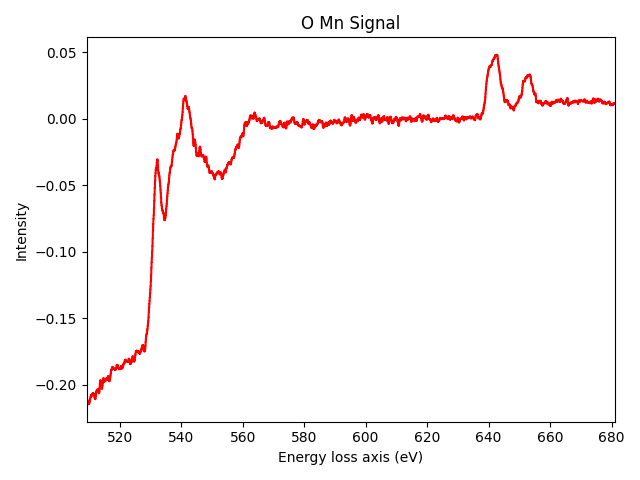

In [33]:
# plot mean background substracted signal to see if it worked properly
signal_background_corrected.mean().plot()

## Deconvolution

In [35]:
# no deconvolution 
signal_deconvolved = signal_normalised.copy()

In [34]:
# Fast deconvolution for core loss
signal_deconvolved= signal_normalised.fourier_log_deconvolution(
                                                zlp = signal_zero_loss, 
                                               add_zlp=False, 
                                               crop=False)
signal_deconvolved.plot()

In [14]:
# slow deconvolution for core loss
signal_deconvolved=signal_normalised.richardson_lucy_deconvolution(psf = signal_zero_loss, 
                                    iterations=1, 
                                    show_progressbar=None, 
                                    num_workers= 36 # None
                                                                            )
signal_deconvolved.plot()

[########################################] | 100% Completed | 101.22 ms


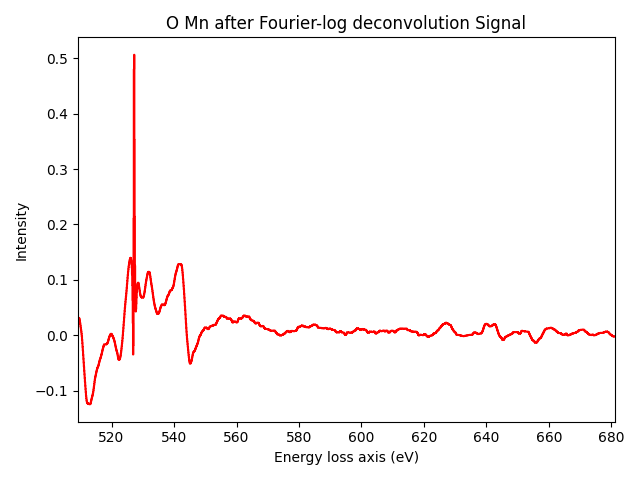

In [26]:
# plot mean background substracted signal to see if it worked properly
signal_deconvolved.mean().plot()

## Filter and smoth Data 

In [ ]:
# No Filter 
signal_filtered = signal_deconvolved.copy()

In [14]:
signal_filtered = signal_deconvolved.copy()
signal_filtered.gaussian_filter(FWHM= 1.5) 
signal_filtered.plot()

In [17]:
signal_filtered = signal_deconvolved.copy()
signal_filtered.filter_butterworth(cutoff_frequency_ratio=0.2, 
                                   type='low',
                                   order=2, 
                                   display=True, 
                                   toolkit=None)
signal_filtered.plot()

In [26]:
signal_filtered = signal_deconvolved.copy()
signal_filtered.smooth_lowess(smoothing_parameter=0.1, 
                              number_of_iterations=2, 
                              show_progressbar=None, 
                              num_workers=36, 
                              display=True, 
                              toolkit=None)
signal_filtered.plot()

[########################################] | 100% Completed | 6.34 ss


In [38]:
signal_filtered = signal_deconvolved.copy()
signal_filtered.smooth_savitzky_golay(polynomial_order=6, 
                                      window_length= 5, 
                                      differential_order=0, 
                                      num_workers=36, 
                                      display=True,
                                      toolkit=None)
signal_filtered.plot()

In [36]:
signal_filtered = signal_deconvolved.copy()
signal_filtered.smooth_tv(smoothing_parameter=6., 
                          show_progressbar=None, 
                          num_workers=36, 
                          display=True, 
                          toolkit=None)
signal_filtered.plot()

[########################################] | 100% Completed | 101.84 ms
[########################################] | 100% Completed | 201.95 ms
[########################################] | 100% Completed | 202.00 ms
[########################################] | 100% Completed | 301.40 ms
[########################################] | 100% Completed | 1.41 ss
[########################################] | 100% Completed | 1.42 s
[########################################] | 100% Completed | 1.51 s
[########################################] | 100% Completed | 1.51 s
[########################################] | 100% Completed | 1.51 s


## Save results

In [ ]:
file_ending = '.hspy'
signal_filtered.save(filepath+'/'+file+'_processed'+file_ending)

## Plot Peak Map

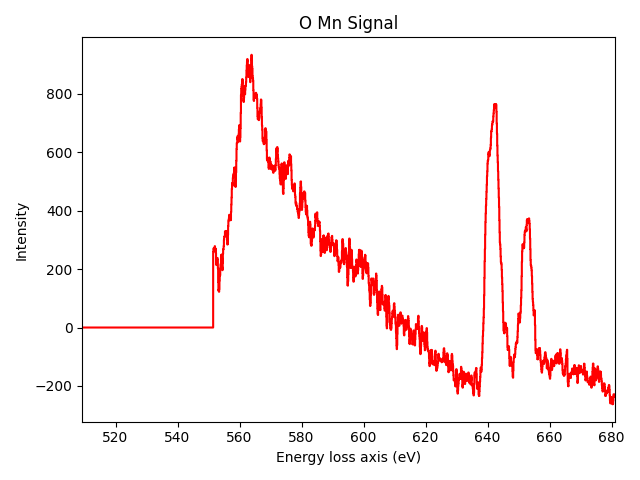

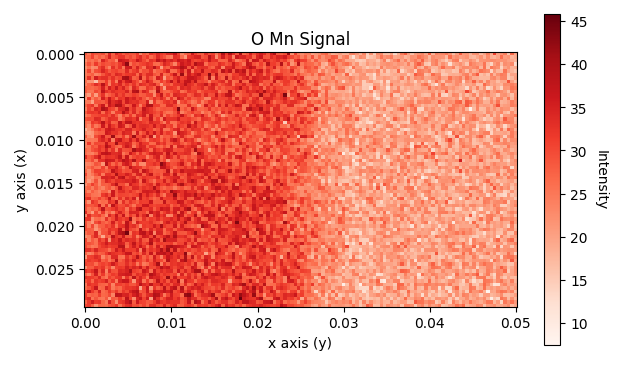

In [36]:
all_sum, rois, roi_signals, roi_sums = hs.plot.plot_roi_map(signal = signal_filtered, rois = 1)

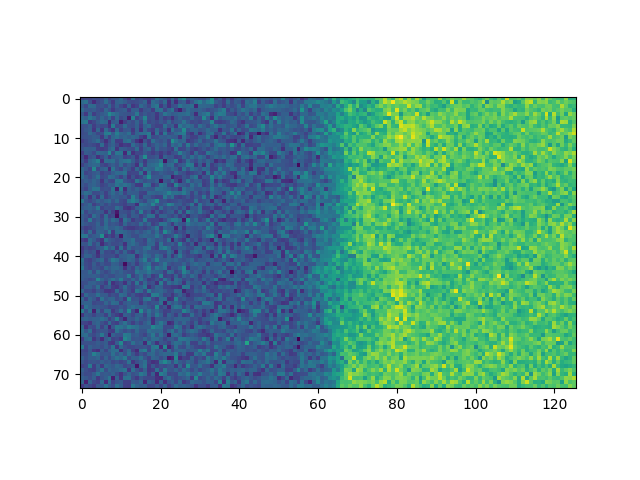

In [9]:
image = np.asarray(roi_sums)
fig, ax = plt.subplots()
for i in range(image.shape[0]):
    ax.imshow(image[i,:,:])
plt.show()